# ML that can See: Supervised Learning with Images 

Let's load in any libraries we will use in this notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms

#this is a nice progress bar representation that will be good to measure progress during training
import tqdm
import copy
import random

# fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# setup device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available
print(f"Using device: {device}")

Using device: cuda:0


# 1. The Data

We will use a subset of the **Stanford Dogs** dataset for **fine-grained image classification**. Our subset contains **20 dog breeds**, and the goal is to train a model to classify images into these classes. The dataset is already organized on disk into two main subfolders.

The `train` and `test` folders contain subdirectories corresponding to the dog breeds (i.e. the class labels).  
- The `train` folder will be used to create the **training** and **validation** sets (for hyperparameter tuning).
- The `test` folder will be used as the **test set** to report final performance.

### Task 1:

1. Load the dataset using  
   [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html), which loads images from a directory structure and **automatically assigns class labels** based on subfolder names.
2. Load **one image from each class** and plot them as a **mosaic** using `matplotlib`. 


Trainval dataset size: 1633
Test dataset size: 2000


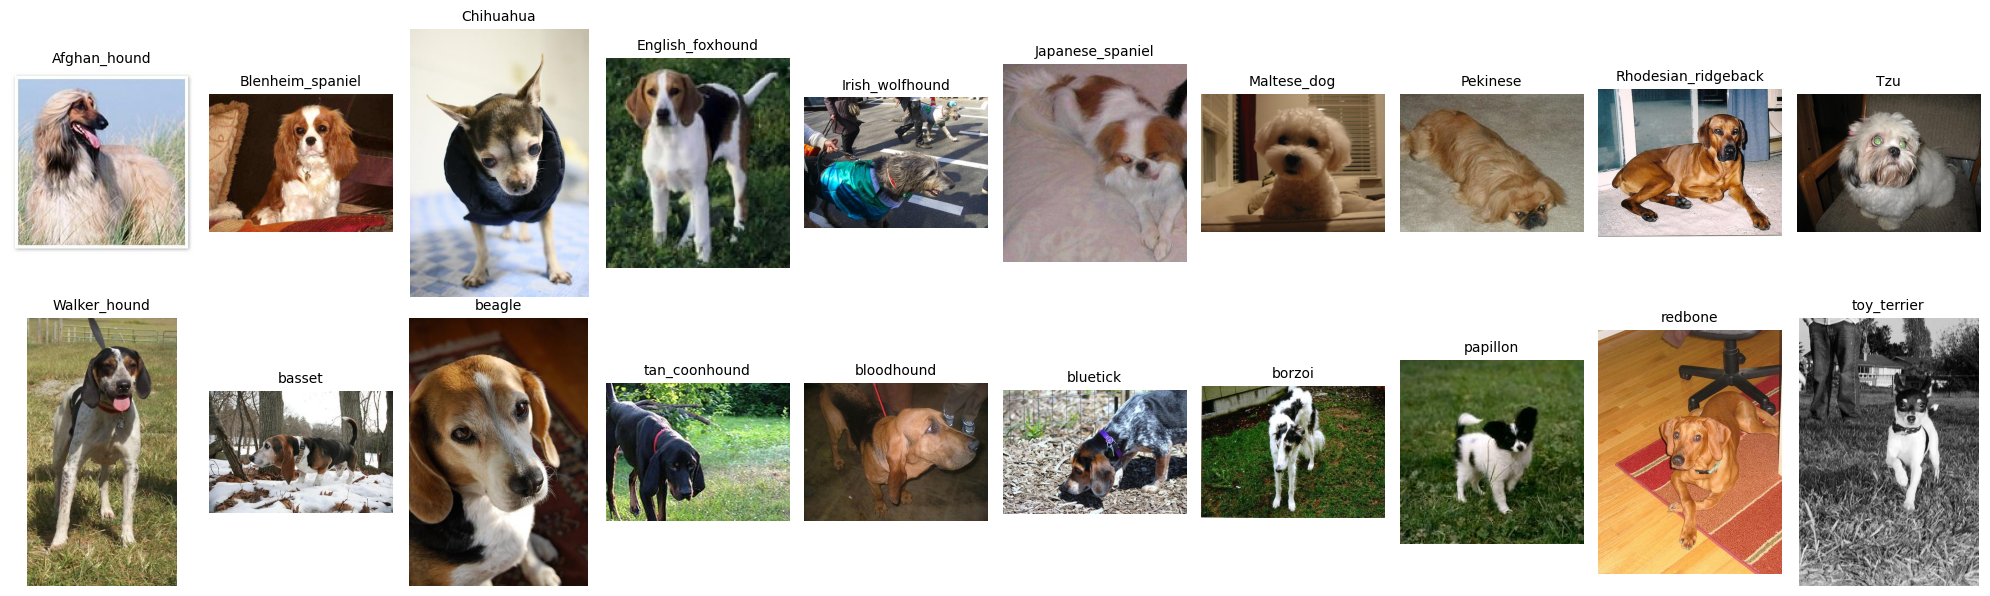

In [2]:
# Load the full training dataset first (without transforms for now)
trainval_dataset = torchvision.datasets.ImageFolder('stanford_dogs_subset/train')
test_dataset = torchvision.datasets.ImageFolder('stanford_dogs_subset/test')

print(f'Trainval dataset size: {len(trainval_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Plot one random sample from each class in a horizontal stripe
num_classes = 20
fig, axes = plt.subplots(2, 10, figsize=(20, 6))

# Get class names
class_names = trainval_dataset.classes
dataset_labels = np.array([label for _, label in trainval_dataset.samples])

# For each class, find one sample and plot it
for class_idx in range(num_classes):
    class_indices = np.where(dataset_labels == class_idx)[0] 
    
    # Pick a random sample from this class
    sample_idx = np.random.choice(class_indices)
    
    # Load and display the image
    img, _ = trainval_dataset[sample_idx]

    row, col = int(class_idx // 10), int(class_idx % 10)
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_names[class_idx].split('-')[-1], fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

We should also examine the distribution of samples across the different classes.

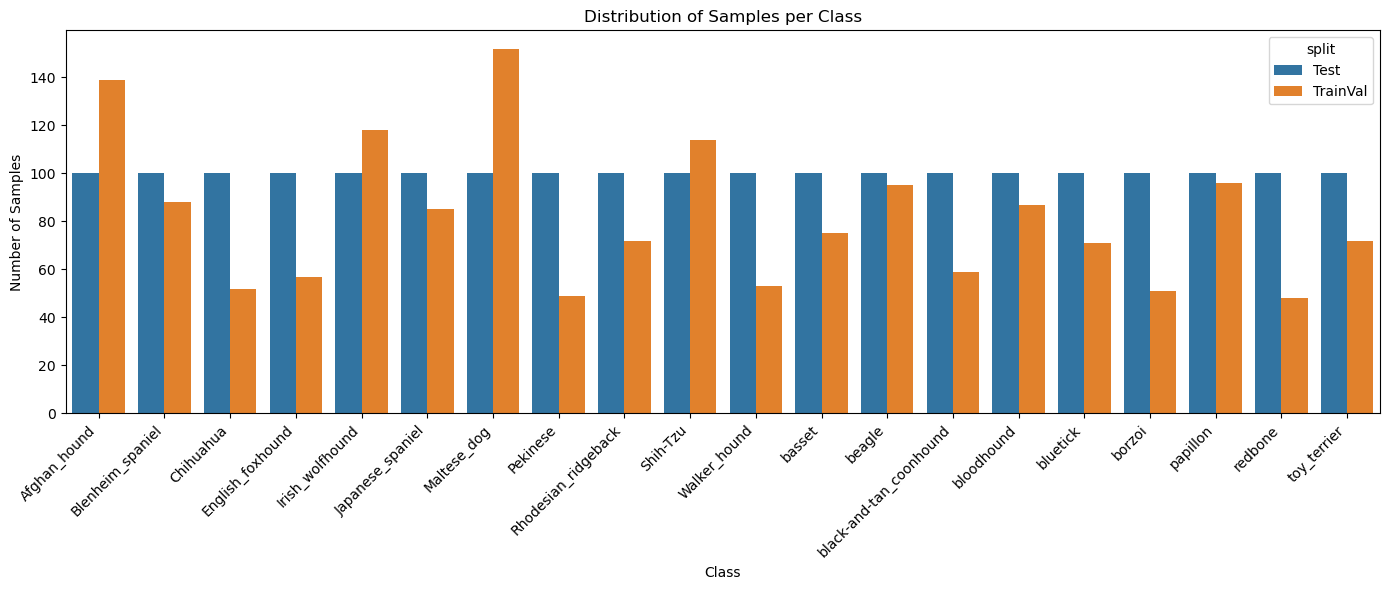

In [3]:

def plot_class_distribution(*datasets, dataset_names=None, figsize=(14, 6)):
    """
    Plot the distribution of samples per class for multiple datasets.
    
    Args:
        *datasets: Variable number of ImageFolder datasets or Subsets
        dataset_names: List of names for each dataset (optional)
        figsize: Figure size (width, height)
    """
    
    if dataset_names is None:
        dataset_names = [f'dataset_{i}' for i in range(len(datasets))]
    
    # Collect data from all datasets
    df_list = []
    for dataset, name in zip(datasets, dataset_names):
        # Handle both ImageFolder and Subset datasets
        if hasattr(dataset, 'samples'):
            # ImageFolder dataset
            labels_full = [label for _, label in dataset.samples]
            class_names = dataset.classes
        else:
            # Subset dataset - get labels from indices
            labels_full = [dataset.dataset.targets[i] for i in dataset.indices]
            class_names = dataset.dataset.classes
        
        df = pd.DataFrame({
            'class': [class_names[label] for label in labels_full],
            'split': name,
            'count': 1
        })
        df_list.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(df_list)
    
    # Group by class and split, then count
    df_grouped = combined_df.groupby(['class', 'split']).count().reset_index()
    
    # Create grouped bar plot
    plt.figure(figsize=figsize)
    sns.barplot(data=df_grouped, x='class', y='count', hue='split')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Samples per Class')
    plt.tight_layout()
    plt.show()

# Plot the distribution
plot_class_distribution(trainval_dataset, test_dataset, dataset_names=['TrainVal', 'Test'])

## Dataset Splitting
Note that the classes contain **different numbers of samples**. This class imbalance should be taken into account when splitting the `trainval` dataset into **training** and **validation** sets. To preserve the class distribution in both splits, we use **stratification**.

### Task 2:  
Split the `trainval` dataset into **training (80%)** and **validation (20%)** sets using **stratified sampling**.

**Hint:**  
You can use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
 function from `sklearn`, with the `stratify` argument.


Total trainval samples: 1633
Training samples: 1306
Validation samples: 327


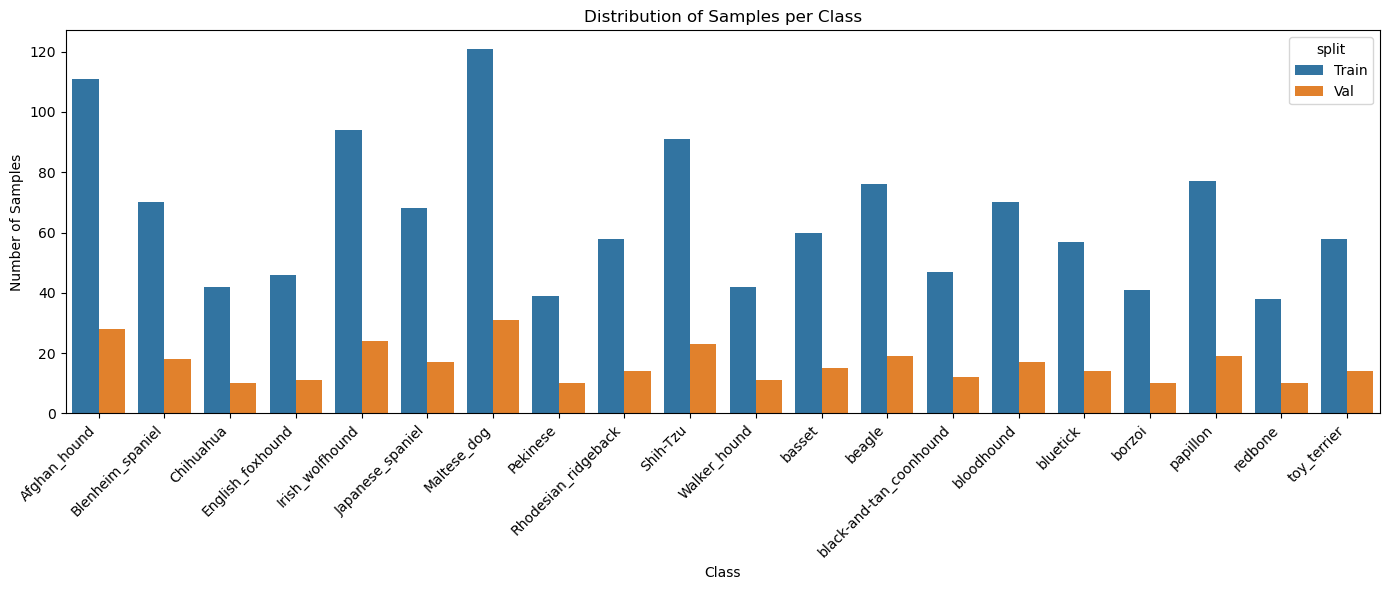

In [4]:
# Get all indices and labels
indices = list(range(len(trainval_dataset)))
labels = [label for _, label in trainval_dataset.samples]

# Perform stratified split to maintain class distribution
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=labels,  # This ensures each class has the same proportion in train/val
    random_state=42
)

# Create subset datasets
train_dataset = torch.utils.data.Subset(trainval_dataset, train_indices)
val_dataset = torch.utils.data.Subset(copy.deepcopy(trainval_dataset), val_indices)

print(f"Total trainval samples: {len(trainval_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
plot_class_distribution(train_dataset, val_dataset, dataset_names=['Train', 'Val'])

## Data Preprocessing, Augmentation, and Loading

Since our dataset is relatively small and the images have **different sizes**, we need to perform a few preprocessing steps before feeding them to a deep learning model. PyTorch transforms module provides these functionalities:

1. **Preprocessing:**  
   - [`transforms.Resize`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) – resize all images to a fixed size so they are compatible with the network (often 224 x 224 pixels).  
   - [`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html) – convert images to PyTorch tensors and scale pixel values to the range [0, 1].  
   - [`transforms.Normalize`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html) – normalize images using **ImageNet mean and standard deviation**, required when fine-tuning models pretrained on ImageNet.

2. **Data Augmentation:**  
   To artificially increase the effective dataset size and reduce overfitting, we can apply **random transformations** to training images, such as:  
   - [`RandomResizedCrop`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomResizedCrop.html) – randomly crops and resizes images.  
   - [`RandomHorizontalFlip`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html) – randomly flips images horizontally.  
   - [`RandomVerticalFlip`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomVerticalFlip.html) – randomly flips images vertically.  
   - [`RandomRotation`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html) – randomly rotates images.  
   - [`ColorJitter`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html) – randomly adjusts brightness, contrast, saturation, and hue.

   These transformations, applied sequentially and randomly, generate a wide variety of images from the same originals, helping the model generalize better.

3. **Loading data in batches:**  
   Deep learning models use **stochastic optimization**, processing images in batches rather than all at once. PyTorch’s [`DataLoader`](https://pytorch.org/vision/stable/data.html) class efficiently loads data in batches, shuffles the training set, and can use multiple worker threads for faster loading.

### Task 3:

1. **Preprocessing:**  
   - Create a **transform pipeline** that resizes, converts to tensor, and normalizes images using ImageNet statistics.  
   - Apply this transform to the validation and test datasets.


3. **Data Augmentation:**  
   - Create a **transform pipeline for training** that includes preprocessing and at least 2–3 random augmentations from the list above.  
   - Apply this transform to the training dataset.


4. **DataLoader:**  
   - Create a **DataLoader** for each dataset (training, validation, and test).  
   - Choose a suitable batch size.  
   - Shuffle the training DataLoader; do not shuffle validation or test DataLoaders.  
   - Optionally, use multiple workers to speed up loading.

5.  **visualize a single batch from the training dataloader.**


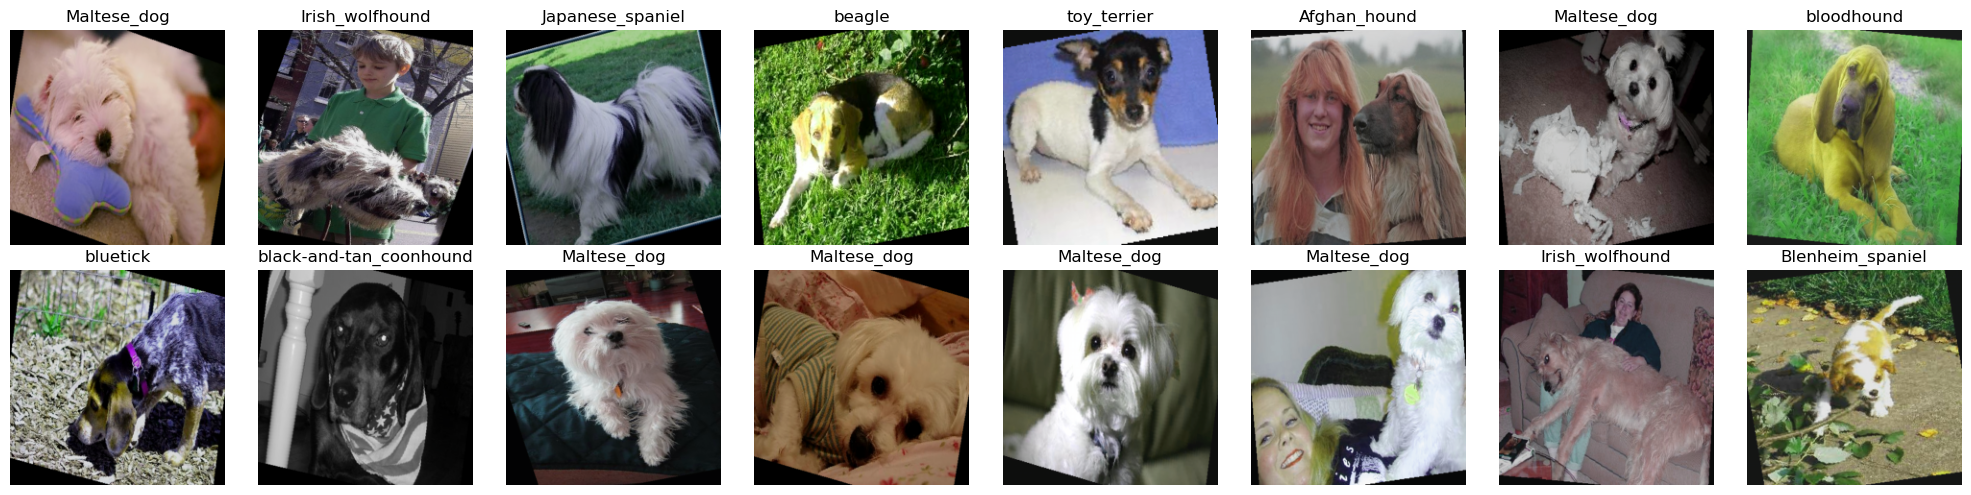

In [5]:

# Imnagenet preprocessing
imagenet_means = (0.485, 0.456, 0.406)
imagenet_stds = (0.229, 0.224, 0.225)

# preprocessing transform
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((224, 224)), 
    transforms.Normalize(imagenet_means, imagenet_stds)])


# Data augmentation transforms for training set
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(15),
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ])

# Apply transforms to the datasets
train_dataset.dataset.transform = transforms.Compose([train_transform,transform])
val_dataset.dataset.transform = transform
test_dataset.transform = transform

# create dataloaders for train, val, test datasets
batch_size = 16
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

# Visualize a batch of augmented training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot the batch
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
axes = axes.ravel()
for idx in range(min(16, len(images))):
    # Denormalize the image for visualization
    img = images[idx].numpy().transpose((1, 2, 0))
    # just remap for visualization
    img = img * np.array(imagenet_stds) + np.array(imagenet_means)
    img = np.clip(img, 0, 1)
    
    axes[idx].imshow(img)
    axes[idx].set_title(class_names[labels[idx]])
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 2. The Model

This week we will use a pretrained ResNet18, that has been trained on ImageNet, but we will be freezing certain parameters in the model so that their weights do not update. We will do this to try and prevent the model from overfitting to the new, small dataset. You can also experiment other pretrained models provided by [PyTorch torchvision library](https://pytorch.org/vision/stable/models.html#classification).

When we create a model for transfer learning, we should follow these steps:
1. Initialise the model with pretrained weights.
2. Adapt the architecture for the new number of classes in our new dataset by changing the final linear layer.
3. If necessary, freeze any weights.

In [6]:
def setup_model(model, num_classes, freeze_backbone = False):
    
    #### Adapt the architecture for the new number of classes.
    in_features = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    #### If necessary, freeze any weights.
    if freeze_backbone: 
        for param in model.parameters():
            param.requires_grad = False
        
        # Unfreeze the parameters of the last fully connected layer
        for param in model.fc.parameters():
            param.requires_grad = True

    return model

backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet_frozen = setup_model(backbone, 20, True)
print(resnet_frozen)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 3. Training the Model with Transfer Learning

Now that we know how to set up our model using **transfer learning**, we can start training it.

We will use a **fine-tuning approach**, where the model’s parameters are slightly adjusted to adapt its learned features to the specific nuances of the new task. In this tutorial, we will **only update the parameters of the final linear layer**, keeping all other layers frozen. You can also experiment with training from scratch or finetune all layers.

In the lecture, we reviewed the general training procedure:

1. **Initialize the model.**
2. **Define a loss function** (also called cost function or objective function).
3. **Initialize the optimizer.**
4. For `n` epochs (or until the loss converges/stops changing):
    1. **Training phase:**  
       - Put the model in training mode with `model.train()`.  
       - For each batch in the **training dataset**:           
           1. Perform a forward pass to compute predictions.
           2. Calculate the **loss** and **accuracy**.
           3. Perform a backward pass to compute gradients with respect to the parameters.
           4. Update the parameters using the optimizer.
    2. **Validation phase:**  
       - Put the model in evaluation mode with `model.eval()`.  
       - For each batch in the **validation dataset**:
           1. Perform a forward pass to compute predictions.
           2. Calculate the **loss** and **accuracy**.

### Task 4
In the cells below, implement the **training** and **validation** functions as described above.


In [7]:
def train_epoch(model, dataloader, criterion, optimizer, epoch, device):

    # Put the model in "train" mode
    model.train() 

    # For all batches in the training dataset
    train_loss, correct, total = [], 0.0, 0.0
    for _, data in  tqdm.tqdm(enumerate(dataloader, 0), total = len(dataloader), desc = f'Epoch {epoch+1} - training phase'):
        # get the inputs and labels from the dataloader and move to device (GPU or CPU)
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero-out the gradients for this batch
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        
        # calculate the loss, gradients with backpropagation, and update the weights
        loss = criterion(outputs, labels)        
        loss.backward()        
        optimizer.step()

        # accumulate loss and accuracy stats
        train_loss += [loss.cpu().item()]
        predicted = torch.argmax(outputs, axis = 1)        
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    # average stats for the epoch
    mean_train_loss = np.mean(train_loss)
    train_accuracy = correct/total
    print(f"Training {epoch+1}: loss={mean_train_loss:.3f} acc={train_accuracy:.3f}")

    return mean_train_loss, train_accuracy


In [8]:
def eval_epoch(model, dataloader, criterion, epoch, device):

    # Put the model in "eval" mode
    model.eval()
    
    #Validation loop: For all batches in the validation dataset
    with torch.no_grad(): # not build the computation graph for backpropagation, and thus, no gradients will be computed or stored for the tensors involved in those operations.
        val_loss, val_correct, val_total = 0.0, 0.0, 0.0
        for i, data in  tqdm.tqdm(enumerate(dataloader, 0), total = len(dataloader), desc = f'Epoch {epoch+1} - validation phase'):
            # get the inputs and labels from the dataloader and move to device (GPU or CPU)
            inputs, labels = data            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(inputs)
            predicted = torch.argmax(outputs, axis = 1)
            
            # calculate the loss and accuracy at the validation split
            loss = criterion(outputs, labels)
            val_loss += loss.cpu().item() * inputs.size(0)            
            val_correct += torch.sum(predicted == labels).cpu().item()
            val_total += inputs.size(0)
    
    
    mean_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total
    print(f"Validation {epoch+1}: loss={mean_val_loss:.3f} acc={val_accuracy:.3f}")
    return mean_val_loss, val_accuracy

Now let’s put everything together and train our model. Remember to save the best model, defined as the one that achieves the highest accuracy on the validation set at any epoch.

Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.61it/s]

Training 1: loss=2.439 acc=0.305



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.34it/s]


Validation 1: loss=1.545 acc=0.621


Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]

Training 2: loss=1.522 acc=0.615



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


Validation 2: loss=1.011 acc=0.768


Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]

Training 3: loss=1.177 acc=0.704



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s]


Validation 3: loss=0.794 acc=0.835


Epoch 4 - training phase: 100%|██████████| 82/82 [00:18<00:00,  4.49it/s]

Training 4: loss=1.004 acc=0.754



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.49it/s]

Validation 4: loss=0.690 acc=0.826



Epoch 5 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.64it/s]

Training 5: loss=0.872 acc=0.786



Epoch 5 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s]

Validation 5: loss=0.617 acc=0.829



Epoch 6 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 6: loss=0.822 acc=0.784



Epoch 6 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]


Validation 6: loss=0.572 acc=0.847


Epoch 7 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 7: loss=0.768 acc=0.792



Epoch 7 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.35it/s]


Validation 7: loss=0.517 acc=0.853


Epoch 8 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.62it/s]


Training 8: loss=0.698 acc=0.826


Epoch 8 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.91it/s]

Validation 8: loss=0.522 acc=0.850



Epoch 9 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]

Training 9: loss=0.668 acc=0.817



Epoch 9 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s]


Validation 9: loss=0.479 acc=0.872


Epoch 10 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.71it/s]

Training 10: loss=0.638 acc=0.827



Epoch 10 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.89it/s]

Validation 10: loss=0.468 acc=0.859


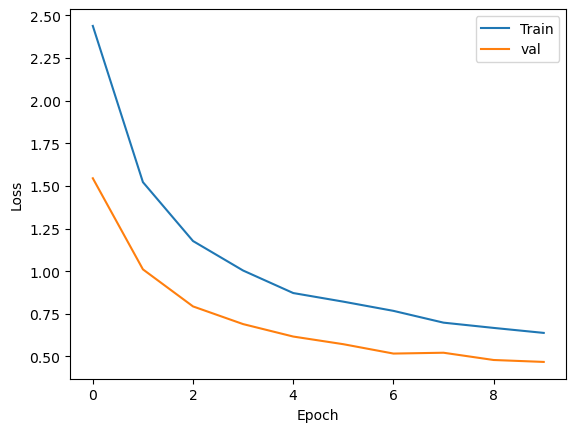

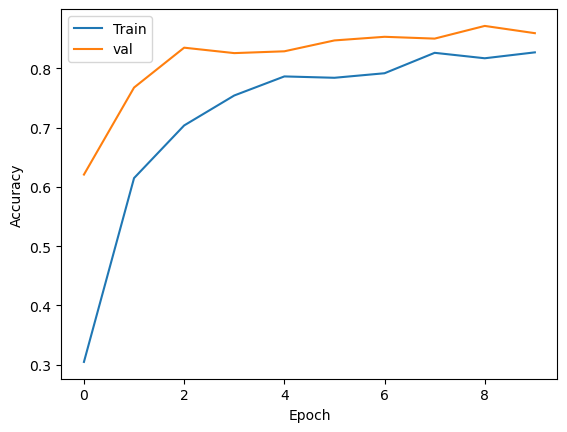

In [16]:
# any hyperparameters
lr = 0.001
total_epochs = 10

#Initialise the model.
backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet_frozen = setup_model(backbone, 20, True)
resnet_frozen = resnet_frozen.to(device)
# Define a loss function
criterion = nn.CrossEntropyLoss()

# Initialise the SGD optimizer.
optimizer = optim.SGD(resnet_frozen.parameters(), lr=lr, momentum=0.9)

#Step 4: For n epochs (e.g. loss converged/stops changing)
total_train_loss, total_val_loss = [], []
total_train_acc, total_val_acc = [], []
best_acc = -np.inf
for epoch in range(total_epochs):    

    # train for one epoch
    mean_train_loss, train_accuracy = train_epoch(resnet_frozen, trainloader, criterion, optimizer, epoch, device)
    total_train_loss.append(mean_train_loss); total_train_acc.append(train_accuracy);

    # evaluate on validation set
    mean_val_loss, val_accuracy = eval_epoch(resnet_frozen, valloader, criterion, epoch, device)
    total_val_loss.append(mean_val_loss); total_val_acc.append(val_accuracy);

    # save the best model based on validation accuracy
    if val_accuracy > best_acc:
        torch.save(resnet_frozen.state_dict(), "resnet_frozen_best.pth")
        best_acc = val_accuracy
        print(f"Best model found at epoch {epoch} with accuracy of {best_acc:.3f}")


# Plot training and validation loss and accuracy curves
plt.plot(total_train_loss, label = 'Train')
plt.plot(total_val_loss, label = 'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(total_train_acc, label = 'Train')
plt.plot(total_val_acc, label = 'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 4. Evaluation

Once our model is trained, the next step is to **evaluate its performance** on the **test set**. Evaluation allows us to understand how well the model generalizes to **unseen data**.

In this tutorial, we will focus on two basic metrics:

1. **Accuracy** – the proportion of correctly predicted labels over all test samples.
2. **Confusion Matrix** – a table that compares true class labels with predicted class labels, showing how many samples of each class are correctly classified and how many are misclassified into other classes. It helps identify which classes the model confuses more often.

> Note: A more detailed discussion of evaluation metrics, such as precision, recall, F1-score, and ROC curves, will be covered in the next tutorial.

For now, your task is to **run the model on the test set**, compute predictions for each sample, and report:

- The **overall accuracy** of the model
- The **confusion matrix** for the test set

### Task 5

1. Load the best model.
2. Iterate over all batches in the **test DataLoader**.  
3. For each sample, compute the **predicted label** using the trained model.  
4. Collect the predictions and the ground-truth labels.  
5. Compute and display:
   - The **overall accuracy** (DONE)
   - The **confusion matrix** (DONE)


Evaluating on test set: 100%|██████████| 125/125 [00:09<00:00, 12.72it/s]


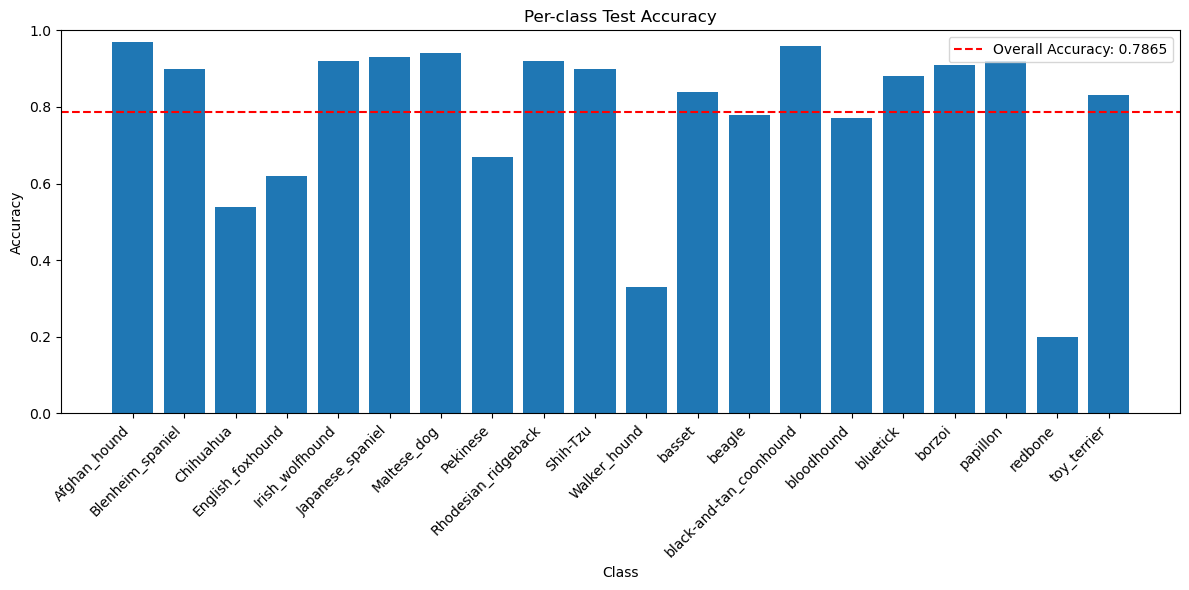

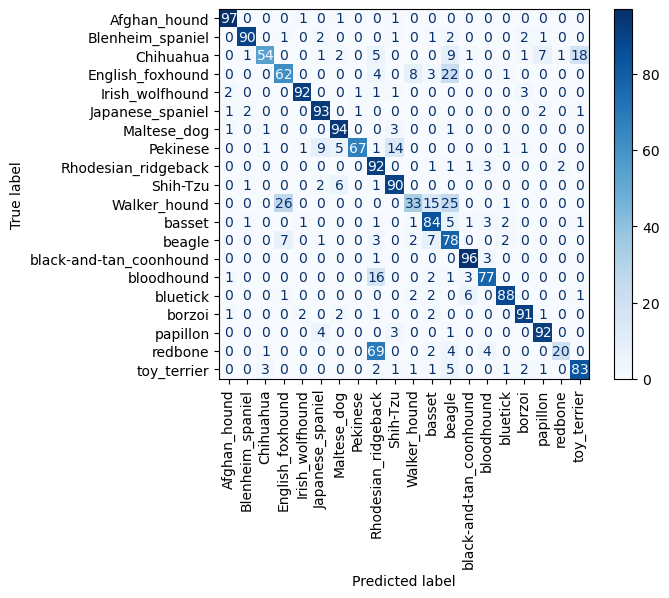

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Load the best model
resnet_frozen.load_state_dict(torch.load("resnet_frozen_best.pth"))
resnet_frozen.eval()

# Collect predictions and ground truth labels
all_predictions = []
all_labels = []

# compute predictions
with torch.no_grad():
    for data in tqdm.tqdm(testloader, desc='Evaluating on test set'):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet_frozen(inputs)
        predicted = torch.argmax(outputs, axis=1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Overall accuracy
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
test_accuracy = np.mean(all_predictions == all_labels)

# Per-class accuracy
class_accuracies = []
for class_idx in range(num_classes):
    class_mask = all_labels == class_idx
    class_accuracies.append((all_predictions[class_mask] == all_labels[class_mask]).sum() /float(class_mask.sum()))

# Visualize per-class accuracy as a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_accuracies)), class_accuracies)
plt.xticks(range(len(class_accuracies)), class_names, rotation=45, ha='right')
plt.xlabel('Class'); plt.ylabel('Accuracy'); plt.title('Per-class Test Accuracy');
plt.ylim([0, 1])
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Overall Accuracy: {test_accuracy:.4f}')
plt.legend(); plt.tight_layout(); plt.show();

# Compute and display confusion matrix using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions, display_labels=class_names, 
                                               cmap=plt.cm.Blues, xticks_rotation='vertical')

# 5. Extensions and Experiments

Once you have completed training and evaluation with the current model, there are many ways you can **experiment and explore on your own** to deepen your understanding of CNNs and transfer learning:

- **Change the backbone network:**  
  Try replacing the current CNN with another architecture, such as **ResNet-50**, **EfficientNet**, or **MobileNet**, and observe how it affects accuracy and training speed.

- **Use a foundation model:**  
  You can explore **pretrained foundation models** such as **DINOv3** or other self-supervised models. Fine-tune them on this dataset and compare their performance to standard CNNs.

- **Handle class imbalance:**  
  If your dataset has classes with very different numbers of samples, try:
  - Using **loss weights** in your loss function to give more importance to underrepresented classes.
  - Using **sampling strategies** in the DataLoader (e.g., [`WeightedRandomSampler`](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler)) to balance the class distribution during training.  
  These methods can help the model learn fairly across all classes.

- **Experiment with data augmentation:**  
  Try adding or modifying augmentations in your training pipeline (e.g., different crop sizes, rotations, color jitter, or even MixUp/CutMix). See how these changes impact generalization.

- **Adjust training parameters:**  
  Experiment with **learning rates**, **batch sizes**, **number of frozen layers**, or **optimizer types** to see how these hyperparameters affect convergence and final accuracy.

- **Visualize model predictions:**  
  Look at misclassified images in the test set or visualize feature maps from intermediate layers to gain insights into what the model has learned.

> Tip: Keep a notebook or log of your experiments. Compare results systematically and try to identify patterns that improve performance. This will help you develop good practices for model development and fine-tuning in real-world scenarios.


# 6. Pro Tip: Hyperparameter Tuning with Optuna

Hyperparameter selection can have a **big impact on model performance**. Instead of manually trying different values, you can use **Optuna**, a Python library for **automated hyperparameter optimization**.

Optuna allows you to:

- Define an **objective function** that trains and evaluates your model with a given set of hyperparameters.  
- Specify **search spaces** for hyperparameters such as learning rate, batch size, optimizer type, or number of frozen layers.  
- Automatically explore the hyperparameter space using **efficient sampling and pruning strategies** to find configurations that maximize performance.  

**Example hyperparameters you could tune:**

- Learning rate (`0.0001` to `0.01`)  
- Batch size (`16`, `32`, `64`)  
- Optimizer (`SGD` vs `Adam`)  
- Weight decay  
- Number of frozen layers in the backbone  

### Challenge: 

As a challenge, you can use **Optuna** in combination with your **training and validation loop**.  

> ⚠️ Note: This process can take a long time, and the study should be **saved to disk** so you can resume or analyze it later (see [Optuna documentation](https://optuna.readthedocs.io/en/stable/)).

Here, we show a minimal example tuning **only the learning rate**, just for learning purposes.   You can extend this to **other hyperparameters** or more complex workflows.

**Important:** Never use the **test set** during hyperparameter search. Doing so can **lead to overfitting** on the test set and your model may fail when deployed on unseen data.

**Can you beat my model?**


In [20]:
# install optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [optuna]2m1/2 [optuna]


In [9]:
import optuna

# let's just use 4 epochs so it does not take alot of time
total_epochs = 4

# Define objective function
def objective(trial):
    
    ############## Suggest hyperparameters ############       
    lr =  trial.suggest_float("lr", 1e-3, 1e1, log=True)
    # ... more can be included

    ############## Training code as before ##########
    #Initialise the model.
    backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    resnet_frozen = setup_model(backbone, 20, True)
    resnet_frozen = resnet_frozen.to(device)
    
    # Define a loss function
    criterion = nn.CrossEntropyLoss()
    
    # Initialise the SGD optimizer.
    optimizer = optim.SGD(resnet_frozen.parameters(), lr=lr, momentum=0.9)

    #For n epochs (e.g. loss converged/stops changing)
    total_train_loss, total_val_loss = [], []
    total_train_acc, total_val_acc = [], []
    best_acc = -np.inf
    for epoch in range(total_epochs):    
    
        # train for one epoch
        mean_train_loss, train_accuracy = train_epoch(resnet_frozen, trainloader, criterion, optimizer, epoch, device)
        total_train_loss.append(mean_train_loss); total_train_acc.append(train_accuracy);
    
        # evaluate on validation set
        mean_val_loss, val_accuracy = eval_epoch(resnet_frozen, valloader, criterion, epoch, device)
        total_val_loss.append(mean_val_loss); total_val_acc.append(val_accuracy);
    
        # save validation accuracy to report to optuna
        if val_accuracy > best_acc:            
            best_acc = val_accuracy            

    ############## give to optuna the best metric found (i.e. validation accuracy). Optuna will try to maximize this ############  
    
    return best_acc

# Run Optuna study
study = optuna.create_study(study_name="hyperparameter Optimization", direction="maximize", storage="sqlite:///optuna_study.db",)
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-12-19 01:39:03,742] A new study created in RDB with name: hyperparameter Optimization
Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]

Training 1: loss=3.416 acc=0.466



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.02it/s]

Validation 1: loss=1.977 acc=0.709



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 2: loss=2.687 acc=0.650



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.32it/s]

Validation 2: loss=1.415 acc=0.783



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]

Training 3: loss=2.659 acc=0.689



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s]

Validation 3: loss=1.240 acc=0.823



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]

Training 4: loss=1.796 acc=0.744



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.12it/s]
[I 2025-12-19 01:40:21,619] Trial 0 finished with value: 0.8226299694189603 and parameters: {'lr': 0.04119051336177415}. Best is trial 0 with value: 0.8226299694189603.


Validation 4: loss=1.873 acc=0.807


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]

Training 1: loss=16.593 acc=0.440



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.58it/s]

Validation 1: loss=5.020 acc=0.740



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]

Training 2: loss=9.525 acc=0.646



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]

Validation 2: loss=5.522 acc=0.746



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.71it/s]

Training 3: loss=7.515 acc=0.706



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.57it/s]

Validation 3: loss=8.328 acc=0.743



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.63it/s]

Training 4: loss=7.390 acc=0.727



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.77it/s]
[I 2025-12-19 01:41:38,729] Trial 1 finished with value: 0.7920489296636085 and parameters: {'lr': 0.1260217041428209}. Best is trial 0 with value: 0.8226299694189603.


Validation 4: loss=5.877 acc=0.792


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.70it/s]

Training 1: loss=1.640 acc=0.515



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s]

Validation 1: loss=0.569 acc=0.810



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.74it/s]

Training 2: loss=0.852 acc=0.711



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.27it/s]

Validation 2: loss=0.692 acc=0.792



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.70it/s]

Training 3: loss=0.672 acc=0.783



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.51it/s]

Validation 3: loss=0.478 acc=0.847



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 4: loss=0.554 acc=0.823



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.08it/s]
[I 2025-12-19 01:42:54,989] Trial 2 finished with value: 0.8470948012232415 and parameters: {'lr': 0.007343358421187438}. Best is trial 2 with value: 0.8470948012232415.


Validation 4: loss=0.484 acc=0.817


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]

Training 1: loss=1.688 acc=0.492



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.60it/s]

Validation 1: loss=0.567 acc=0.798



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.73it/s]

Training 2: loss=0.854 acc=0.724



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.28it/s]

Validation 2: loss=0.616 acc=0.823



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 3: loss=0.713 acc=0.769



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.47it/s]

Validation 3: loss=0.443 acc=0.862



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 4: loss=0.605 acc=0.798



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.20it/s]
[I 2025-12-19 01:44:11,258] Trial 3 finished with value: 0.8623853211009175 and parameters: {'lr': 0.008416651358498123}. Best is trial 3 with value: 0.8623853211009175.


Validation 4: loss=0.414 acc=0.859


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.70it/s]

Training 1: loss=1.819 acc=0.465



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s]

Validation 1: loss=0.723 acc=0.761



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.70it/s]

Training 2: loss=0.867 acc=0.732



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.63it/s]

Validation 2: loss=0.536 acc=0.838



Epoch 3 - training phase: 100%|██████████| 82/82 [00:18<00:00,  4.55it/s]

Training 3: loss=0.689 acc=0.786



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.26it/s]

Validation 3: loss=0.473 acc=0.841



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.63it/s]

Training 4: loss=0.638 acc=0.802



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.17it/s]
[I 2025-12-19 01:45:28,626] Trial 4 finished with value: 0.8562691131498471 and parameters: {'lr': 0.0044182100288929285}. Best is trial 3 with value: 0.8623853211009175.


Validation 4: loss=0.416 acc=0.856


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]

Training 1: loss=7.002 acc=0.482



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.24it/s]

Validation 1: loss=6.167 acc=0.661



Epoch 2 - training phase: 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]

Training 2: loss=5.635 acc=0.642



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.96it/s]

Validation 2: loss=4.895 acc=0.688



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 3: loss=4.418 acc=0.682



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.59it/s]

Validation 3: loss=3.851 acc=0.768



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]

Training 4: loss=4.232 acc=0.708



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.36it/s]
[I 2025-12-19 01:46:45,687] Trial 5 finished with value: 0.8379204892966361 and parameters: {'lr': 0.07070442401502539}. Best is trial 3 with value: 0.8623853211009175.


Validation 4: loss=2.326 acc=0.838


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]

Training 1: loss=1.745 acc=0.470



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.20it/s]

Validation 1: loss=0.658 acc=0.758



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]

Training 2: loss=0.849 acc=0.725



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.25it/s]

Validation 2: loss=0.464 acc=0.841



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]

Training 3: loss=0.735 acc=0.764



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.68it/s]

Validation 3: loss=0.670 acc=0.810



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]

Training 4: loss=0.694 acc=0.766



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.30it/s]
[I 2025-12-19 01:48:02,356] Trial 6 finished with value: 0.8562691131498471 and parameters: {'lr': 0.010706848847762459}. Best is trial 3 with value: 0.8623853211009175.


Validation 4: loss=0.476 acc=0.856


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]

Training 1: loss=7.203 acc=0.449



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s]

Validation 1: loss=2.703 acc=0.777



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.61it/s]

Training 2: loss=4.762 acc=0.659



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.30it/s]

Validation 2: loss=4.720 acc=0.737



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.64it/s]

Training 3: loss=4.113 acc=0.721



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.95it/s]

Validation 3: loss=3.597 acc=0.804



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]

Training 4: loss=3.258 acc=0.758



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.48it/s]
[I 2025-12-19 01:49:19,688] Trial 7 finished with value: 0.8042813455657493 and parameters: {'lr': 0.06833483303962737}. Best is trial 3 with value: 0.8623853211009175.


Validation 4: loss=4.691 acc=0.749


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.67it/s]

Training 1: loss=2.297 acc=0.336



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.16it/s]

Validation 1: loss=1.293 acc=0.685



Epoch 2 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]

Training 2: loss=1.328 acc=0.666



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.61it/s]

Validation 2: loss=0.841 acc=0.777



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]

Training 3: loss=1.010 acc=0.753



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 13.53it/s]

Validation 3: loss=0.715 acc=0.789



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]

Training 4: loss=0.871 acc=0.770



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.21it/s]
[I 2025-12-19 01:50:36,942] Trial 8 finished with value: 0.8287461773700305 and parameters: {'lr': 0.0014044553150660579}. Best is trial 3 with value: 0.8623853211009175.


Validation 4: loss=0.581 acc=0.829


Epoch 1 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.64it/s]

Training 1: loss=323.838 acc=0.432



Epoch 1 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 12.79it/s]

Validation 1: loss=108.289 acc=0.740



Epoch 2 - training phase: 100%|██████████| 82/82 [00:18<00:00,  4.48it/s]

Training 2: loss=149.876 acc=0.668



Epoch 2 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.06it/s]

Validation 2: loss=106.878 acc=0.734



Epoch 3 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.64it/s]

Training 3: loss=158.403 acc=0.685



Epoch 3 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.44it/s]

Validation 3: loss=119.823 acc=0.755



Epoch 4 - training phase: 100%|██████████| 82/82 [00:17<00:00,  4.63it/s]

Training 4: loss=134.382 acc=0.712



Epoch 4 - validation phase: 100%|██████████| 21/21 [00:01<00:00, 14.08it/s]
[I 2025-12-19 01:51:54,860] Trial 9 finished with value: 0.7553516819571865 and parameters: {'lr': 2.292664865510413}. Best is trial 3 with value: 0.8623853211009175.


Validation 4: loss=191.506 acc=0.743
Best hyperparameters: {'lr': 0.008416651358498123}
Best accuracy: 0.8623853211009175
